In [1]:
%matplotlib inline
import copy
from qutip import *
import numpy as np
import math, cmath
import matplotlib.pyplot as plt
from tqdm import tqdm

import utilities as use
from stateobj import QState, QAncilla, JointSystem

from IPython.display import Markdown, display

In [2]:
UNITARY_EVOLUTION = True
MEQ_EVOLUTION = True
U_ID = None
MEQ_ID = None  # string (systems dimentions-timesteps-timedelta)
PLOT = True
# Set HISTORICAL = True to track histories of Systems evolutions
HISTORICAL = False

TIMESTEPS = 80000
TIMEDELTA = 1e-2
OMEGA = 10  # Strength of Interaction

## System

In [3]:
system_dimentions = 2
system_energy = 1
system1 = use.create_system('fock', n_dims=system_dimentions, n=0)
system2 = use.create_system('fock', n_dims=system_dimentions, n=1)
# Tensor Product state
system = JointSystem([system1, system2])
display(system1)
display(system2)
display(type(system))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]

stateobj.JointSystem

## Ancilla

In [4]:
alpha = complex(1/math.sqrt(2), 0)
beta = complex(1/math.sqrt(2), 0)
phi = np.pi/3
eta = QAncilla(alpha=alpha, beta=beta, phi=phi)
stable_temperature = - system1.energy / math.log(eta.factor)
# Stampa informazioni sull'Ancella
display(eta)
display(Markdown(
    f"This will thermalize the System to $T = {stable_temperature}$")
)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.5  +0.j         0.   +0.j         0.   +0.j        ]
 [0.   +0.j         0.25 +0.j         0.125+0.21650635j]
 [0.   +0.j         0.125-0.21650635j 0.25 +0.j        ]]

This will thermalize the System to $T = -3.476059496782208$

## Interaction

In [5]:
ap_int = [tensor(system.ap[i], qeye(3)) for i in range(len(system.systems))]
am_int = [tensor(system.am[i], qeye(3)) for i in range(len(system.systems))]
# Ladder Operators for the Ancilla
bp_int = tensor(qeye(system_dimentions), qeye(system_dimentions), eta.sigmaminus)
bm_int = tensor(qeye(system_dimentions), qeye(system_dimentions), eta.sigmaplus)
# Interaction 
V = [OMEGA*(ap_int[i]*bp_int + am_int[i]*bm_int) for i in range(len(system.systems))]
# Unitary Evolution Operator
U = [(-1j*V[i]*TIMEDELTA).expm() for i in range(len(system.systems))]

In [6]:
rho_u = copy.deepcopy(system)
rho_u

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [7]:
if UNITARY_EVOLUTION:
    temperatures_u = []
    coherences_u = []
    for i in tqdm(range(TIMESTEPS)):
        rho_u = rho_u.interact(eta, V, TIMEDELTA, historical=HISTORICAL)
        temperatures_u.append([rho_u[0].get_temperature(), rho_u[1].get_temperature()])
        coherences_u.append(rho_u.full()[2, 1].real)
    if U_ID is not None:
            qsave(rho_u, f'objects/jointss_unitary_{U_ID}')
            np.save(f'objects/jointtemp_unitary_{U_ID}', temperatures_u)
            np.save(f'objects/jointcoh_unitary_{U_ID}', coherences_u)
    display(rho_u)
else:
    try:
        """Carica i file delle Temperature e lo stato del Sistema"""
        rho_u = qload(f'objects/jointss_unitary_{U_ID}')
        temperatures_u = np.load(f'objects/jointtemp_unitary_{U_ID}.npy')
        coherences_u = np.load(f'objects/jointcoh_unitary_{U_ID}.npy')
        PLOT = True
        display(rho_u)
    except FileNotFoundError as e:
        print('Error!\n', str(e))
        PLOT = False

100%|█████████████████████████████████████| 80000/80000 [26:59<00:00, 49.41it/s]


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.18367347+0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.24489796+0.00000000e+00j
  0.        -1.08420217e-19j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.        +1.08420217e-19j
  0.24489796+0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.32653061+0.00000000e+00j]]

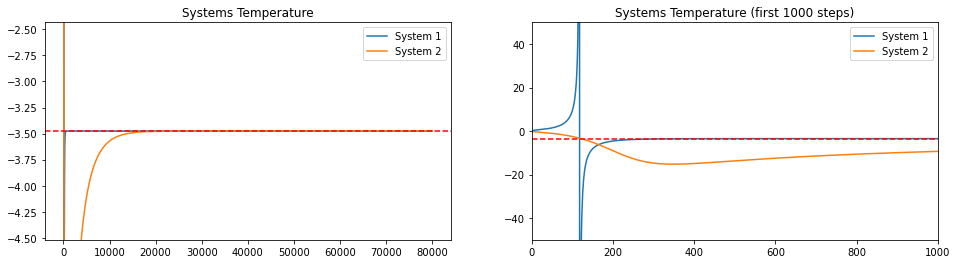

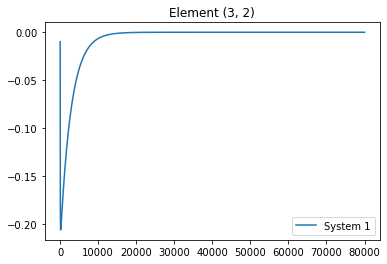

In [32]:
if PLOT:
    fig, axs = plt.subplots(1,2, figsize=(16,4))
    axs[0].plot(temperatures_u)
    axs[0].set_title('Systems Temperature')
    axs[0].legend(['System 1', 'System 2'])
    axs[0].set_ylim(stable_temperature+0.3*stable_temperature, stable_temperature-0.3*stable_temperature,)
    #plt.ylim(-10,10)
    axs[0].axhline(stable_temperature, ls='--', color='r', label=f'Stable Temperature: {stable_temperature:.4}')
    axs[1].plot(temperatures_u)
    axs[1].set_title('Systems Temperature (first 1000 steps)')
    axs[1].legend(['System 1', 'System 2'])
    axs[1].set_xlim(0, 1000)
    axs[1].set_ylim(-50,50)
    #set_ylim(stable_temperature+0.3*stable_temperature, stable_temperature-0.3*stable_temperature,)
    axs[1].axhline(stable_temperature, ls='--', color='r', label=f'Stable Temperature: {stable_temperature:.4}')
    plt.show()
    # Non diagonal element ( [3, 2] )
    plt.plot(coherences_u)
    plt.title('Element (3, 2)')
    plt.legend(['System 1', 'System 2'])
    plt.show()

# Master Equation Evolution
$$
    \frac{\Delta \rho_{n}}{\Delta t} = -\frac{i}{2}[H_S'+H_S''; \rho_{n-1}] + \frac{1}{4}\mathcal{D}_S[\rho_{n-1}]
$$

$$
\begin{align}
    &H_S' = \hbar\Omega\sum_\nu\langle B_\nu \rangle\left( A_{1\nu}+A_{2\nu} \right) \\
    &H_S'' = i\frac{\Delta t}{4}(\hbar\Omega)^2\sum_{\mu\nu}\langle [B_\nu;B_\mu] \rangle A_{2\mu}A_{1\nu} \\
    &\mathcal{D}_S[\rho] = (\hbar\Omega)^2\Delta t\sum_{\mu\nu}\langle B_\mu B_\nu \rangle 
        \left( A_\nu\rho_{n-1}A_\mu-\frac{1}{2}[A_\mu A_\nu; \rho_{n-1}] \right)
\end{align}
$$

### First Moments

In [9]:
print(f'{"ExpVal":5}\t{"Computed":10}\t{"Theoretical":10}\n'
      f'<B->\t{expect(eta.sigmaplus, eta).real}\t\t{0}\n'
      f'<B+>\t{expect(eta.sigmaminus, eta).real}\t\t{0}')

ExpVal	Computed  	Theoretical
<B->	0.0		0
<B+>	0.0		0


### Commutator Moments

In [10]:
theoretical = 2*eta.alpha**2 - eta.beta**2 * (1 + math.cos(eta.phi))
print(f'{"ExpVal":10}\t{"Computed":20}\t{"Theoretical":20}\n'
      f'<[B- ; B+]>\t{expect(commutator(eta.sigmaplus, eta.sigmaminus), eta).real}\t{theoretical.real}\n'
      f'<[B+ ; B-]>\t{expect(commutator(eta.sigmaminus, eta.sigmaplus), eta).real}\t{-theoretical.real}')

ExpVal    	Computed            	Theoretical         
<[B- ; B+]>	0.24999999999999983	0.25
<[B+ ; B-]>	-0.24999999999999983	-0.25


### Second Moments

In [11]:
print(f'ExpVal\t{"Computed":10}\t{"Theoretical":10}\n'
      f'<B-B->\t{expect(eta.sigmaplus*eta.sigmaplus, eta).real}\t\t{0}\n'
      f'<B+B+>\t{expect(eta.sigmaminus*eta.sigmaminus, eta).real}\t\t{0}')

ExpVal	Computed  	Theoretical
<B-B->	0.0		0
<B+B+>	0.0		0


### Cross Correlations

In [12]:
print(f'ExpVal\t{"Computed":20}\t{"Theoretical":20}\n'
      f'<B-B+>\t{expect(eta.sigmaplus*eta.sigmaminus, eta).real}\t{(2*eta.alpha**2).real}\n'
      f'<B+B->\t{expect(eta.sigmaminus*eta.sigmaplus, eta).real}\t{(eta.beta**2*(1+math.cos(eta.phi))).real}')

ExpVal	Computed            	Theoretical         
<B-B+>	0.9999999999999998	0.9999999999999998
<B+B->	0.7499999999999999	0.7499999999999998


## Master Equation 

In [13]:
rho_meq = copy.deepcopy(system)
rho_meq

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [14]:
if MEQ_EVOLUTION:
    temperatures_meq = []
    coherences_meq = []
    for i in tqdm(range(TIMESTEPS)):
        rho_meq = rho_meq.meq_step(eta, OMEGA, TIMEDELTA, historical=HISTORICAL)
        temperatures_meq.append([rho_meq[0].get_temperature(), rho_meq[1].get_temperature()])
        coherences_meq.append(rho_meq.full()[2, 1].real)
    if MEQ_ID is not None:
            qsave(rho_meq, f'objects/jointss_meq_{MEQ_ID}')
            np.save(f'objects/jointtemp_meq_{MEQ_ID}', temperatures_meq)
            np.save(f'objects/jointcoh_meq_{MEQ_ID}', coherences_meq)
    display(rho_meq)
else:
    try:
        """Carica i file delle Temperature e lo stato del Sistema"""
        rho_meq = qload(f'objects/jointss_meq_{MEQ_ID}')
        temperatures_meq = np.load(f'objects/jointtemp_meq_{MEQ_ID}.npy')
        coherences_meq = np.load(f'objects/jointcoh_meq_{MEQ_ID}.npy')
        PLOT = True
        display(rho_meq)
    except FileNotFoundError as e:
        print('Error!\n', str(e))
        PLOT = False

100%|████████████████████████████████████| 80000/80000 [13:03<00:00, 102.15it/s]


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.18299424  0.          0.          0.        ]
 [ 0.          0.24557718 -0.00184062  0.        ]
 [ 0.         -0.00184062  0.24611036  0.        ]
 [ 0.          0.          0.          0.32531821]]

In [15]:
display(rho_meq[0])
display(rho_u[0])
display(rho_meq[1])
display(rho_u[1])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.42857143 0.        ]
 [0.         0.57142857]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.42857143 0.        ]
 [0.         0.57142857]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.42910461 0.        ]
 [0.         0.57089539]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.42857143 0.        ]
 [0.         0.57142857]]

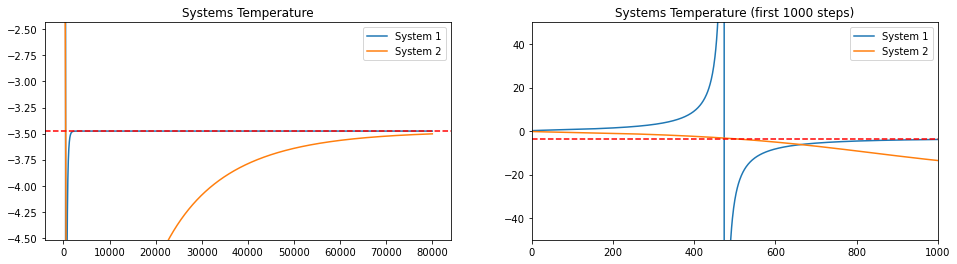

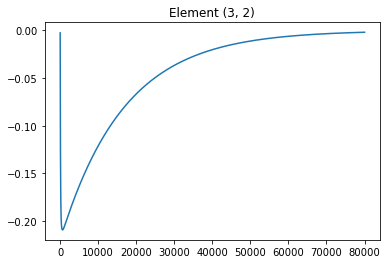

In [34]:
PLOT = True
if PLOT:
    fig, axs = plt.subplots(1,2, figsize=(16,4))
    axs[0].plot(temperatures_meq)
    axs[0].set_title('Systems Temperature')
    axs[0].legend(['System 1', 'System 2'])
    axs[0].set_ylim(stable_temperature+0.3*stable_temperature, stable_temperature-0.3*stable_temperature,)
    #plt.ylim(-10,10)
    axs[0].axhline(stable_temperature, ls='--', color='r', label=f'Stable Temperature: {stable_temperature:.4}')
    axs[1].plot(temperatures_meq)
    axs[1].set_title('Systems Temperature (first 1000 steps)')
    axs[1].legend(['System 1', 'System 2'])
    axs[1].set_xlim(0, 1000)
    axs[1].set_ylim(-50,50)
    #set_ylim(stable_temperature+0.3*stable_temperature, stable_temperature-0.3*stable_temperature,)
    axs[1].axhline(stable_temperature, ls='--', color='r', label=f'Stable Temperature: {stable_temperature:.4}')
    plt.show()
    # Non diagonal element ( [3, 2] )
    plt.plot(coherences_meq)
    plt.title('Element (3, 2)')
    plt.show()